In [1]:
from astropy.io import fits
import h5py
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import treecorr 

In [2]:
folder = '/global/projecta/projectdirs/lsst/groups/WL/users/jprat/gaussian_sims_srdnzs_fullsky/012922/'
filepath_txpipe_inputs = '/global/projecta/projectdirs/lsst/groups/WL/users/jprat/gaussian_sims_srdnzs_fullsky/012922/area12300/TXPipe_inputs/'

## Compute what declination cut we need to mimic LSST Y1 area

In [3]:
def deg2_to_rad2(deg2):
    return deg2*(np.pi/180)**2

def h_func(A, r):
    return A/(2*np.pi) # A = 2*pi*h

def dec_lim_func(h, r):
    return np.pi/2-np.arccos(h/r)

# We want to get an area of 12,300 deg^2 (LSST Y1)

A = deg2_to_rad2(12300)
h = h_func(A, r=1)
dec_lim = -dec_lim_func(h, r=1)*180/np.pi # negative because lsst is in the south
print(h)
print(dec_lim)

0.5963208277647292
-36.606848299424534


## Now mask the source catalogs

In [5]:
for zbin in range(1,6):
    filename = 'shearcat_shearalm_zbin%d_ra_dec_g1_g2_withshapenoise_v012922'%zbin
    cat = np.load(folder + filename + '.npy')
    ra, dec, g1, g2 = cat.T
    mask = (dec>dec_lim)&(dec<0)
    print(len(ra))
    ra_cut, dec_cut, g1_cut, g2_cut = ra[mask], dec[mask], g1[mask], g2[mask]
    print(len(ra_cut))
    print(np.std(g1_cut))
    #np.save(folder + '/area12300/' + filename + '_areacut', (ra_cut,dec_cut,g1_cut,g2_cut))

264347918
78809359
0.3705111106525768
264347918
78809359
0.37054935986402265
264347918
78809359
0.3706879719176018
264347918
78809359
0.3707776276597527
264347918
78809359
0.3708535482189473


In [6]:

for zbin in range(1,6):
    filename = 'shearcat_shearalm_zbin%d_ra_dec_g1_g2_v012922'%zbin
    cat = np.load(folder + filename + '.npy')
    ra, dec, g1, g2 = cat.T
    mask = (dec>dec_lim)&(dec<0)
    print(len(ra))
    ra_cut, dec_cut, g1_cut, g2_cut = ra[mask], dec[mask], g1[mask], g2[mask]
    print(len(ra_cut))
    print(np.std(g1_cut))
    #np.save(folder + '/area12300/' + filename + '_areacut', (ra_cut,dec_cut,g1_cut,g2_cut))

264347918
78818335
0.003482623686757737
264347918
78805305
0.0064893328935679406
264347918
78813519
0.009764555290384011
264347918
78810204
0.013987489219832934
264347918
78809359
0.016379693562984212


## Compute twopoint functions

#### Compute cosmic shear for this catalog

In [7]:
zbin = 5
filename = 'shearcat_shearalm_zbin%d_ra_dec_g1_g2_v012922'%zbin
cat = np.load(folder + filename + '.npy')
ra, dec, g1, g2 = cat.T
mask = (dec>dec_lim)&(dec<0)
print(len(ra))
ra_cut, dec_cut, g1_cut, g2_cut = ra[mask], dec[mask], g1[mask], g2[mask]
print(len(ra_cut))

264347918
78813519


In [14]:
#r = np.random.uniform(low=0.0, high=1.0, size=len(ra_cut))
mask = ra_cut<80
cat_s = treecorr.Catalog(ra=ra_cut[mask], dec=dec_cut[mask], g1=g1_cut[mask], g2=-g2_cut[mask], ra_units='deg', dec_units='deg')

In [29]:
gg = treecorr.GGCorrelation(nbins=15, min_sep=2.5, max_sep = 100, bin_slop=0.1, sep_units='arcmin')
gg.process(cat_s)
th = gg.meanlogr
xip = gg.xip

In [ ]:
gg.npairs

for g1, g2


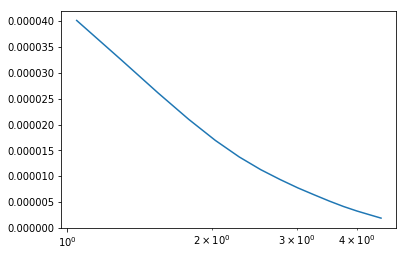

In [30]:
plt.plot(th, xip)
plt.xscale('log')
#plt.yscale('log')
print('for g1, g2')

#### Compute gglensing

In [4]:
zbin = 4
cat = np.load(folder + '/area12300/' + 'galcat_%d'%zbin + '_areacut.npy')
ra_l, dec_l = cat
mask_l = ra_l<150
cat_l = treecorr.Catalog(ra=ra_l[mask_l], dec=dec_l[mask_l],  ra_units='deg', dec_units='deg')
ng = treecorr.NGCorrelation(nbins=15, min_sep=2.5, max_sep = 100, bin_slop=0.1, sep_units='arcmin')

In [5]:
folder + '/area12300/' + 'galcat_%d'%zbin + '_areacut.npy'

'/global/projecta/projectdirs/lsst/groups/WL/users/jprat/gaussian_sims_srdnzs_fullsky/012922//area12300/galcat_4_areacut.npy'

In [16]:
ng.process(cat_l, cat_s)
th = np.exp(ng.logr)
gt = ng.xi

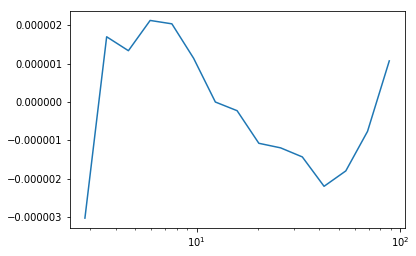

In [17]:
plt.plot(th, gt)
plt.xscale('log')
#plt.yscale('log')

#### Compute wtheta

In [6]:
path_outputs =  '/global/cscratch1/sd/jprat/TXPipe/data/gaussian_sims/outputs_gaussian_sims/gaussian_sims_srdnzs_fullsky/012922/area12300/without_shape_noise/2022/Feb4/'
rancat = h5py.File(path_outputs + 'binned_random_catalog.hdf5', 'r')
ra_r = rancat['randoms/bin_3/ra'][:]
dec_r = rancat['randoms/bin_3/dec'][:]
mask_r = ra_r<80
cat_r = treecorr.Catalog(ra=ra_r[mask_r], dec=dec_r[mask_r],  ra_units='deg', dec_units='deg')

In [7]:
len(ra_l[mask_l]), len(ra_r[mask_r])

298696346

In [8]:
len(ra_r)/len(ra_l)

11.646721437767075

In [9]:
nn = treecorr.NNCorrelation(nbins=15, min_sep=2.5, max_sep = 100, bin_slop=0.1, sep_units='arcmin')
nn.process(cat_l)
rr = treecorr.NNCorrelation(nbins=15, min_sep=2.5, max_sep = 100, bin_slop=0.1, sep_units='arcmin')
rr.process(cat_r)
dr = treecorr.NNCorrelation(nbins=15, min_sep=2.5, max_sep = 100, bin_slop=0.1, sep_units='arcmin')
dr.process(cat_l, cat_r)
xi,varxi = nn.calculateXi(rr=rr,dr=dr)

In [15]:
th = np.geomspace(2.5, 100,15)

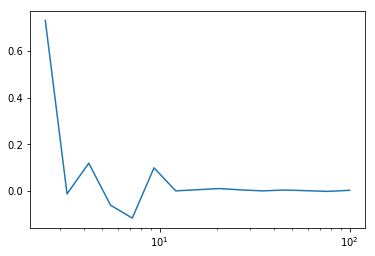

In [19]:
plt.errorbar(th, xi*10, yerr=np.sqrt(varxi))
plt.xscale('log')
#plt.yscale('log')

In [11]:
plt.plot(th, nn.npairs)
#plt.plot(th, rr.npairs)

NameError: name 'th' is not defined

In [36]:
xi, np.sqrt(varxi)

(array([ 7.51394041e-02,  4.99466351e-04,  1.26340077e-02, -5.36084246e-03,
        -1.11114634e-02,  1.02417332e-02,  4.16293433e-04,  7.73767353e-04,
         1.35686263e-03,  7.22364011e-04,  3.65042836e-04,  6.99210006e-04,
         4.29401493e-04,  5.38549709e-05,  5.33303408e-04]),
 array([5.67822092e-05, 4.44094864e-05, 3.47339746e-05, 2.71690611e-05,
        2.12526856e-05, 1.66267713e-05, 1.30089131e-05, 1.01806423e-05,
        7.96851667e-06, 6.23844962e-06, 4.88639096e-06, 3.82850438e-06,
        3.00145050e-06, 2.35498618e-06, 1.84898157e-06]))

## Now cut the lens galaxy catalog

In [7]:
for zbin in range(1,6):
    filename = 'galcat_%d'%zbin
    lenscat = np.load(folder + filename + '_v012922.npy')
    ra, dec = lenscat.T
    mask = (dec>dec_lim)&(dec<0)
    print(len(ra))
    ra_cut, dec_cut = ra[mask], dec[mask]
    print(len(ra_cut))
    np.save(folder + '/area12300/' + filename + '_areacut', (ra_cut,dec_cut))

334429571
99746776
462368754
137860433
458425599
136718808
387115285
115417193
297660758
88745354


# Now joint source files into a single one, to inject to TXPipe, adding columns it needs

In [8]:
# Columns TXPipe needs from the cosmo simulation
cols = ['mag_true_u_lsst', 'mag_true_g_lsst', 
                'mag_true_r_lsst', 'mag_true_i_lsst', 
                'mag_true_z_lsst', 'mag_true_y_lsst',
                'ra', 'dec',
                'ellipticity_1_true', 'ellipticity_2_true',
                'shear_1', 'shear_2',
                'size_true',
                'galaxy_id',
                'redshift_true',
                ]


In [8]:
#assign a fake redshift within z lims so that TXPipe assigns it properly when source selector splits in bins
source_zbin_edges = np.array([0.19285902, 0.40831394, 0.65503818, 0.94499109, 1.2947086, 1.72779632, 2.27855242, 3. ]) # 7 bins
z_fake =[0.3, 0.5, 0.8, 1., 1.4, 1.9, 2.5]
print(z_fake)

[0.3, 0.5, 0.8, 1.0, 1.4, 1.9, 2.5]


In [9]:
ras, decs, g1s, g2s, zs, e1s, e2s = [], [], [], [], [], [], []

for zbin in range(1,6):
    #filename = 'shearcat_shearalm_zbin%d_ra_dec_g1_g2_withshapenoise_v012922'%zbin
    filename = 'shearcat_shearalm_zbin%d_ra_dec_g1_g2_v012922'%zbin
    cat = np.load(folder + '/area12300/' + filename + '_areacut'+'.npy')
    ra, dec, g1, g2 = cat
    ras.extend(ra)
    decs.extend(dec)
    g1s.extend(g1)   
    g2s.extend(g2)
    zs.extend([z_fake[zbin-1]]*len(ra))
    
nobj = len(ras)

# Now fake the rest of the columns we need matching the lenth   
m_u = np.random.uniform(low=20, high=30, size=(nobj,))
m_g = np.random.uniform(low=20, high=30, size=(nobj,))
m_r = np.random.uniform(low=20, high=30, size=(nobj,))
m_i = np.random.uniform(low=20, high=30, size=(nobj,))
m_z = np.random.uniform(low=20, high=30, size=(nobj,))
m_y = np.random.uniform(low=20, high=30, size=(nobj,))
etrue1 = np.random.uniform(low=0, high=0.5, size=(nobj,))
etrue2 = np.random.uniform(low=0, high=0.5, size=(nobj,))
size = np.random.uniform(low=2., high=10., size=(nobj,))
galaxy_id = np.arange(0,nobj, 1, dtype=int)

ras, decs, g1s, g2s, zs = np.array(ras), np.array(decs), np.array(g1s), np.array(g2s), np.array(zs) 
filepath_save = folder + 'area12300/' + 'shearcat_shearalm_allbins_ra_dec_g1_g2_and_fakecols' + '_areacut'
np.save(filepath_save, (ras,decs,g1s,g2s,zs,m_u,m_g, m_r, m_i, m_z, m_y, etrue1, etrue2, size, galaxy_id))


In [5]:
ra,dec,g1,g2,z,m_u,m_g, m_r, m_i, m_z, m_y, etrue1, etrue2, size, galaxy_id = np.load('/global/projecta/projectdirs/lsst/groups/WL/users/jprat/gaussian_sims_srdnzs_fullsky/012922/area12300/shearcat_shearalm_allbins_ra_dec_g1_g2_and_fakecols_withshapenoise_areacut.npy')

In [6]:
r_u = np.random.uniform(low=0.0, high=1.0, size=len(ra))

In [7]:
mask_d = r_u<0.0001
ra_d = ra[mask_d]
dec_d = dec[mask_d]

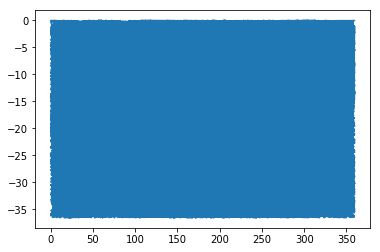

In [8]:
plt.plot(ra_d, dec_d)

In [71]:
# check source counts
for zbin in range(1,6):
    filename = 'shearcat_shearalm_zbin%d_ra_dec_g1_g2_withshapenoise_v012922'%zbin
    cat = np.load(folder + '/area12300/' + filename + '_areacut'+'.npy')
    ra, dec, g1, g2 = cat
    print(g1)
    print(filename)
    print(len(g1))
    

[-0.19064275  0.32866038 -0.60719646 ... -0.23665328 -0.59230241
 -0.12215333]
shearcat_shearalm_zbin1_ra_dec_g1_g2_withshapenoise_v012922
78809359
[-0.02305466  0.10419215 -0.68600679 ...  0.18918448 -0.25354753
  0.05925817]
shearcat_shearalm_zbin2_ra_dec_g1_g2_withshapenoise_v012922
78809359
[-0.07574852  0.80251058 -0.05987507 ...  0.05353942  0.13618739
  0.23388943]
shearcat_shearalm_zbin3_ra_dec_g1_g2_withshapenoise_v012922
78809359
[ 0.11629183  0.50068242  0.42046392 ...  0.49527915 -0.03086783
 -0.12683173]
shearcat_shearalm_zbin4_ra_dec_g1_g2_withshapenoise_v012922
78809359
[ 0.05202255  0.51968553  0.00558584 ...  0.1364006  -0.67195701
 -0.24490451]
shearcat_shearalm_zbin5_ra_dec_g1_g2_withshapenoise_v012922
78809359


## Now produce the lens TXPipe inputs

In [12]:
# we need to fake some of these columns
cols = ['chisq', 'ra','dec', 'zredmagic',
        'mag_g', 'mag_i', 'mag_r', 'mag_y', 'mag_z',
        'mag_err_g', 'mag_err_i', 'mag_err_r', 'mag_err_y', 'mag_err_z']
# let's try first if we can get away with just ra, dec in this cat. 

In [14]:
# Produce the lens_catalog.hdf5
ras, decs = [], []

for zbin in range(1,6):
    cat = np.load(folder + '/area12300/' + 'galcat_%d'%zbin + '_areacut.npy')
    ra, dec = cat
    ras.extend(ra)
    decs.extend(dec)

ras, decs = np.array(ras), np.array(decs)
filepath_save = filepath_txpipe_inputs + 'lens_catalog'

# need to save this in hdf5 format
hf = h5py.File('%s.hdf5'%filepath_save, 'w')
g_lens = hf.create_group('lens')
g_lens.create_dataset('ra',data=ras)
g_lens.create_dataset('dec',data=decs)
hf.close()

In [15]:
filepath_save

'/global/projecta/projectdirs/lsst/groups/WL/users/jprat/gaussian_sims_srdnzs_fullsky/012922/area12300/TXPipe_inputs/lens_catalog'

In [16]:
# Produce the lens_tomography_catalog.hdf5
zbins, counts = [], []

for zbin in range(1,6):
    cat = np.load(folder + '/area12300/' + 'galcat_%d'%zbin + '_areacut.npy')
    ra, dec = cat
    zbins.extend([zbin-1]*len(ra)) #starts with 0 in txpipe
    counts.append(len(ra))

zbins, counts = np.array(zbins), np.array(counts)
counts_2d = np.array([counts.sum()])
ws = np.array([1.]*counts_2d[0])

filepath_save = filepath_txpipe_inputs + 'lens_tomography_catalog'

# need to save this in hdf5 format
hf = h5py.File('%s.hdf5'%filepath_save, 'w')
t_lens = hf.create_group('tomography')
t_lens.create_dataset('lens_bin',data=zbins)
t_lens.create_dataset('lens_counts',data=counts)
t_lens.create_dataset('lens_counts_2d',data=counts_2d )
t_lens.create_dataset('lens_weight',data=ws)
t_lens.attrs['nbin_lens'] = 5
hf.close()

## Let's check what we saved and plot it!

In [17]:
lens_cat_check = h5py.File(filepath_txpipe_inputs + 'lens_catalog.hdf5', 'r')

In [18]:
lens_cat_check['lens'].keys()

<KeysViewHDF5 ['dec', 'ra']>

In [19]:
ra = lens_cat_check['lens/ra'][:]
dec = lens_cat_check['lens/dec'][:]

In [20]:
r_u = np.random.uniform(low=0.0, high=1.0, size=len(ra))

In [21]:
mask_d = r_u<0.001
ra_d = ra[mask_d]
dec_d = dec[mask_d]

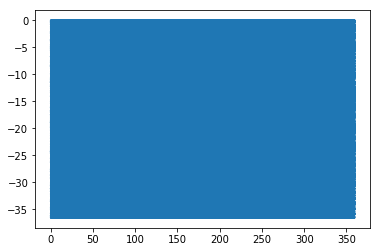

In [22]:
plt.plot(ra_d, dec_d)

In [23]:
lens_tomo_check = h5py.File(filepath_txpipe_inputs + 'lens_tomography_catalog.hdf5', 'r')

In [24]:
lens_tomo_check['tomography/lens_counts'][:]

array([ 99746776, 137860433, 136718808, 115417193,  88745354])

# Now save the redshift distributions in the TXPipe format

In [25]:
# these redshift distributions were used as input for the CLS that go into the generation of the gaussian sims

In [26]:
# Load SRD nzs
lens = np.loadtxt('../generation_gaussian_sims/srd_nzs/nz_y1_lens_5bins_srd.txt').T
source = np.loadtxt('../generation_gaussian_sims/srd_nzs/nz_y1_srcs_5bins_srd.txt').T

z_l = lens[0]
z_s = source[0]
nzs_l = lens[1:]
nzs_s = source[1:]

In [27]:
# Lens sample
pz_l = h5py.File(filepath_txpipe_inputs + 'lens_photoz_stack.hdf5', 'w')
n_of_z = pz_l.create_group('n_of_z')
lens = pz_l.create_group('n_of_z/lens')

l_bins = 5
lens.create_dataset('z',data=z_l)
for i in range(l_bins):
    lens.create_dataset('bin_%d'%i,data=nzs_l[i])
lens.attrs['nbin'] = l_bins
pz_l.close()


In [28]:
# source sample
pz_s = h5py.File(filepath_txpipe_inputs + 'shear_photoz_stack.hdf5', 'w')
n_of_z = pz_s.create_group('n_of_z')
source = pz_s.create_group('n_of_z/source')
source2d = pz_s.create_group('n_of_z/source2d')

source.create_dataset('z',data=z_s)
source2d.create_dataset('z',data=z_s)

s_bins = 5
for i in range(s_bins):
    source.create_dataset('bin_%d'%i,data=nzs_s[i])
source2d.create_dataset('bin_0',data=nzs_s)
source.attrs['nbin'] = s_bins
pz_s.close()

## Check mask that is being created in TXPipe

In [63]:
path_mask = '/global/cscratch1/sd/jprat/TXPipe/data/cosmodc2/outputs_redmagic/2021/december14/7sbins/mask.hdf5'

In [64]:
mask_check = h5py.File(path_mask, 'r')

In [65]:
pix = mask_check['maps/mask/pixel'][:]
value = mask_check['maps/mask/value'][:]

In [79]:
mask_check['maps/mask'].attrs.keys()

<KeysViewHDF5 ['area', 'bright_obj_threshold', 'chunk_rows', 'depth_band', 'f_sky', 'nest', 'npix', 'nside', 'pixelization', 'snr_delta', 'snr_threshold', 'sparse']>

In [87]:
mask_check['maps/mask'].attrs['sparse']

True

In [66]:
len(pix), len(value)

(538406, 538406)

In [67]:
nside = 2048
npix = hp.nside2npix(nside)
#map = np.repeat(hp.UNSEEN, npix)
map = np.zeros(npix)
map[pix] = value

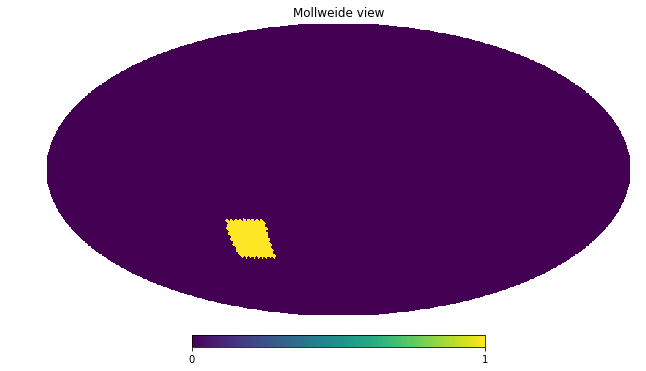

In [68]:
hp.mollview(map)

## Create a mask file on our own since Auxiliary Lens maps doesn't run

In [41]:
lens_cat_check = h5py.File(filepath_txpipe_inputs + 'lens_catalog.hdf5', 'r')
ra = lens_cat_check['lens/ra'][:]
dec = lens_cat_check['lens/dec'][:]

In [42]:
phi = ra*np.pi/180. 
theta = np.pi/2 - dec*np.pi/180.
nside = 2048
pix = hp.ang2pix(nside,theta,phi)
map=  np.bincount(pix,minlength=hp.nside2npix(nside))
map[map>1]=1

filled_pixels = np.unique(pix)
value_of_filled_pixels = np.ones(len(filled_pixels))

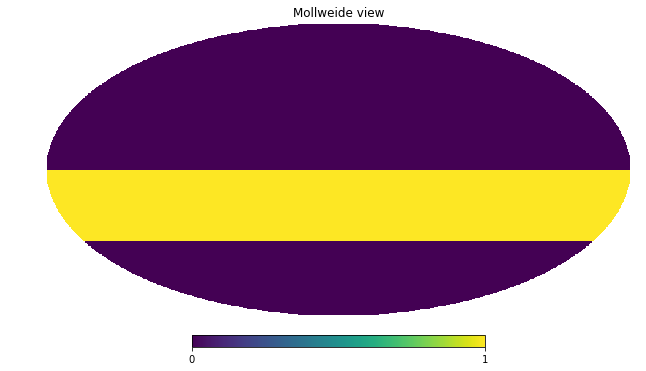

In [43]:
hp.mollview(map)

In [44]:
np.min(ra), np.max(ra), np.min(dec), np.max(dec)

(0.0, 359.9945068359375, -36.60341944121341, -0.004662742478543629)

In [45]:
# Lens sample
mask_file = h5py.File(filepath_txpipe_inputs + 'mask.hdf5', 'w')
maps_group = mask_file.create_group('maps')
mask_group = mask_file.create_group('maps/mask')

mask_group.create_dataset('pixel',data=filled_pixels)
mask_group.create_dataset('value',data=value_of_filled_pixels)
mask_group.attrs['area'] = 12300
mask_group.attrs['bright_obj_threshold'] = 22.
mask_group.attrs['chunk_rows'] = 100000
mask_group.attrs['depth_band'] = 'i'
mask_group.attrs['f_sky'] = 12300/41252.96125
mask_group.attrs['nest'] = False
mask_group.attrs['npix'] = hp.nside2npix(2048)
mask_group.attrs['nside'] = 2048
mask_group.attrs['pixelization'] = 'healpix'
mask_group.attrs['snr_delta'] = 10
mask_group.attrs['snr_threshold'] = 10
mask_group.attrs['sparse'] = True
mask_file.close()
#['area', 'bright_obj_threshold', 'chunk_rows', 'depth_band', 'f_sky', 'nest', 'npix', 'nside', 'pixelization', 'snr_delta', 'snr_threshold', 'sparse'

In [46]:
print(filepath_txpipe_inputs)

/global/projecta/projectdirs/lsst/groups/WL/users/jprat/gaussian_sims_srdnzs_fullsky/012922/area12300/TXPipe_inputs/


### Check mask we saved

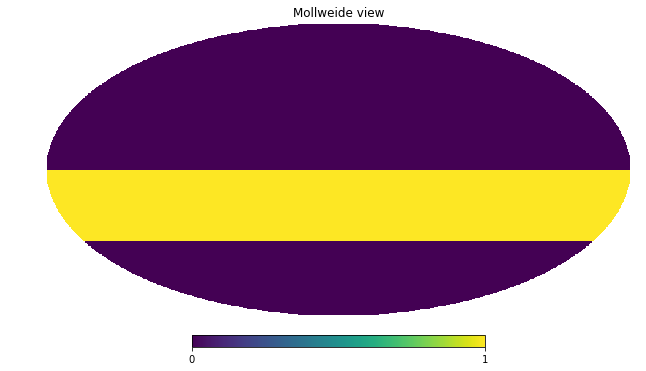

In [49]:
path_mask = filepath_txpipe_inputs + 'mask.hdf5'
mask_check = h5py.File(path_mask, 'r')

pix = mask_check['maps/mask/pixel'][:]
value = mask_check['maps/mask/value'][:]

nside = 2048
npix = hp.nside2npix(nside)
#map = np.repeat(hp.UNSEEN, npix)
map = np.zeros(npix)
map[pix] = value

hp.mollview(map)

In [54]:
        import healpy 
        group = mask_check['maps/mask']
        nside = group.attrs['nside']
        npix = healpy.nside2npix(nside)
        m = np.repeat(healpy.UNSEEN, npix)
        pix = group['pixel'][:]
        val = group['value'][:]
        m[pix] = val

(15015936, 15015936, 50331648, None)

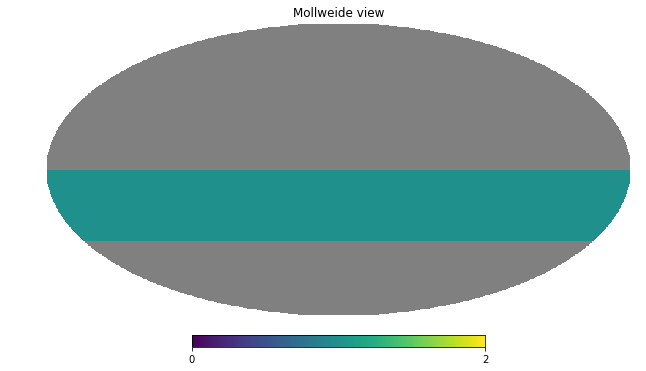

In [59]:
len(pix), len(val), len(m), hp.mollview(m)

In [58]:
len(pix), len(value), len(map)

(15015936, 15015936, 50331648)

In [65]:
        # Make a fake depth map                                                                                                                                                                                                                                                                                                                                             
        pix_d = m > 0
        depth = m.copy()
        depth[pix_d] = 25  #e.g. 25 everywhere   
        

In [68]:
len(depth), len(pix)

(50331648, 15015936)

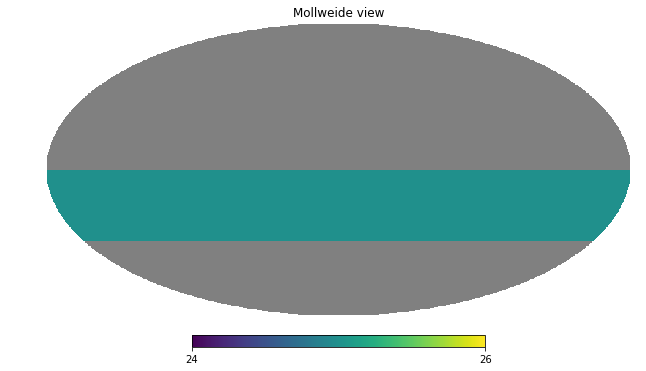

In [62]:
hp.mollview(depth)

In [64]:
len(pix_d), len(depth), len(depth[pix_d])

(50331648, 50331648, 15015936)

In [50]:
mask_check['maps/mask/'].attrs.keys()

<KeysViewHDF5 ['area', 'bright_obj_threshold', 'chunk_rows', 'depth_band', 'f_sky', 'nest', 'npix', 'nside', 'pixelization', 'snr_delta', 'snr_threshold', 'sparse']>

In [36]:
def read_area(map):

    num_hit = np.sum(m[m>0]) # Assuming fracdet mask                                                                                                                                                    
    area_sq_deg = pixel_scheme.pixel_area(degrees=True) * num_hit
    f_sky = float(area_sq_deg) / 41252.96125
    print(f"Area = {area_sq_deg:.2f} deg^2")
    return float(area_sq_deg)

In [37]:
np.sum(map)/map.shape[0]* 41252.96125

12307.402013549805

## Now create uniform random points based on that mask

In [8]:
#Function to generate random points given some limits. 
def make_random(min_ra,max_ra,min_dec,max_dec,num):
    '''
    Function that outputs RA and DEC of a 'square' random catalog in the given limits.

    Parameters
    ----------
    min_ra,max_ra,min_dec,max_dec : RA, DEC limits
    num : number of random points to be thrown to whole sphere, less than the final number of points in the given area.
    Returns
    -------
    ra_rand, dec_rand : arrays of random RA and DEC in the given limits.
    
    '''
    ra_rand = (np.random.random(num)* (max_ra - min_ra))  + min_ra
    v = np.random.random(num)
    v *= 2
    v -= 1
    dec_rand = np.arccos(v)
    np.rad2deg(dec_rand,dec_rand)
    dec_rand -= 90.0
    dec_rand_sel =((dec_rand < max_dec)&(dec_rand > min_dec))
    #Joining RA and DEC, only for area limits
    ra_rand, dec_rand = ra_rand[dec_rand_sel],dec_rand[dec_rand_sel]
    return ra_rand, dec_rand



In [11]:
ra_r, dec_r = make_random(0., 360.,dec_lim,0,10000)

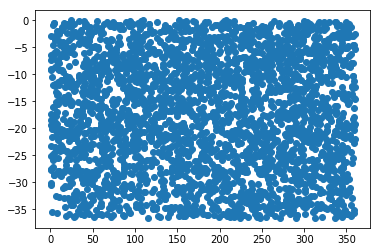

In [12]:
plt.scatter(ra_r, dec_r)

In [13]:
len(ra)

578477033

In [16]:
## check randoms output file
path_randoms = '/global/cscratch1/sd/jprat/TXPipe/data/cosmodc2/outputs_redmagic/2021/december14/7sbins/random_cats.hdf5'
cat_randoms = h5py.File(path_randoms, 'r')

In [18]:
cat_randoms['randoms'].keys()

<KeysViewHDF5 ['bin', 'dec', 'ra', 'z']>

In [21]:
cat_randoms['randoms/z'][0:10]

array([0.20389755, 0.24207751, 0.24313499, 0.21370121, 0.33716676,
       0.22836577, 0.3187912 , 0.30164284, 0.25098322, 0.22718581])